In [ ]:
from IPython.display import Markdown as md
import datetime
import os
try:
    os.chdir(os.path.join(os.getcwd(), '../'))
    print(os.getcwd())
except:
    pass

In [ ]:
# Configure opentelemetry. This has to be done before we import anything we want to trace

from opentelemetry import trace
from opentelemetry.exporter import jaeger
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import BatchExportSpanProcessor
from opentelemetry.instrumentation.requests import RequestsInstrumentor

RequestsInstrumentor().instrument()
trace.set_tracer_provider(TracerProvider())
jaeger_exporter = jaeger.JaegerSpanExporter(
    service_name="COVID-19-Poland-notebook",
    agent_host_name="localhost",
    agent_port=6831,
)
span_processor = BatchExportSpanProcessor(jaeger_exporter)
trace.get_tracer_provider().add_span_processor(span_processor)
tracer = trace.get_tracer(__name__)

# Poland daily data

In [3]:
import Poland.figures as fig_pl
import Poland.poland_stats as pl
import World.countries as countries


population = countries.load_countries_data()
pl_population = population['Poland']
NO_OF_DAYS = 90

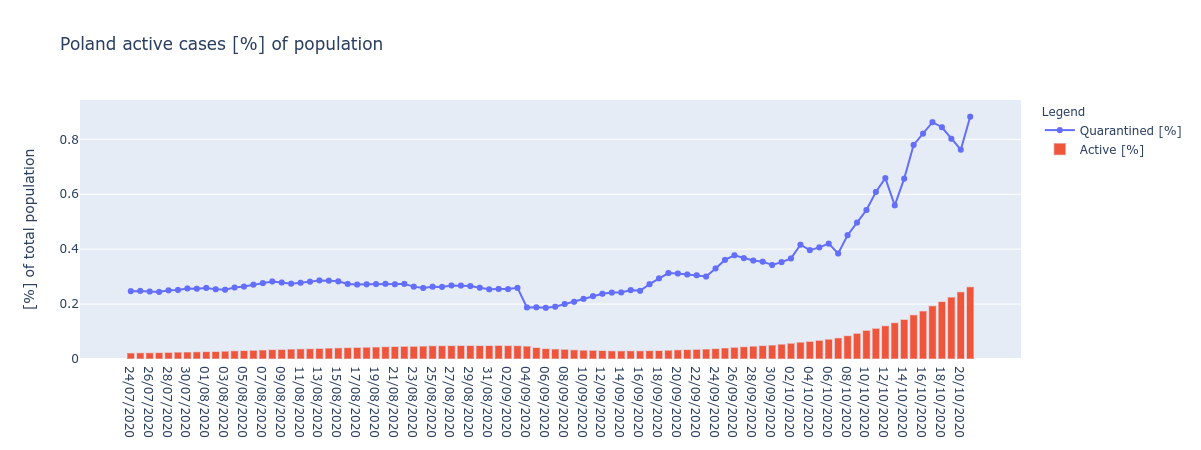

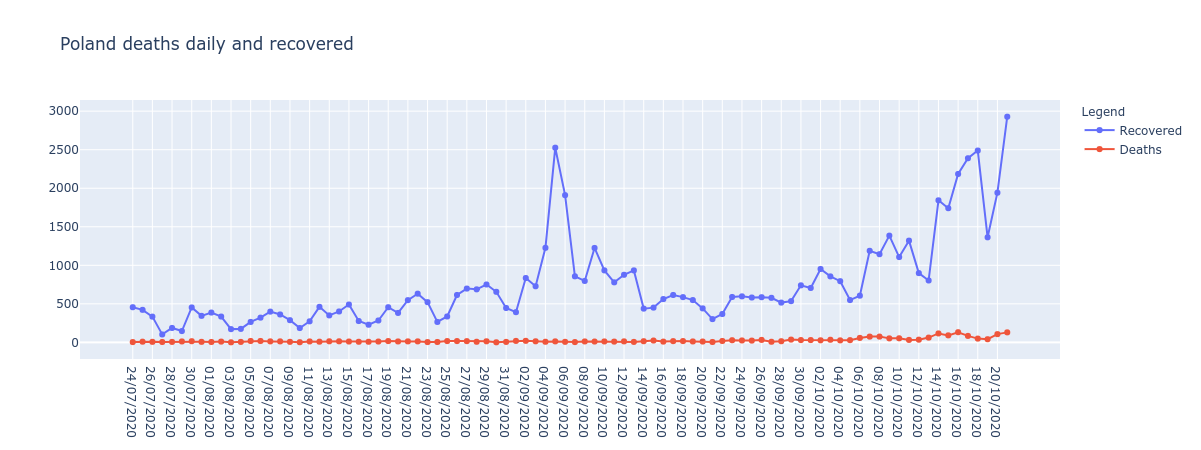

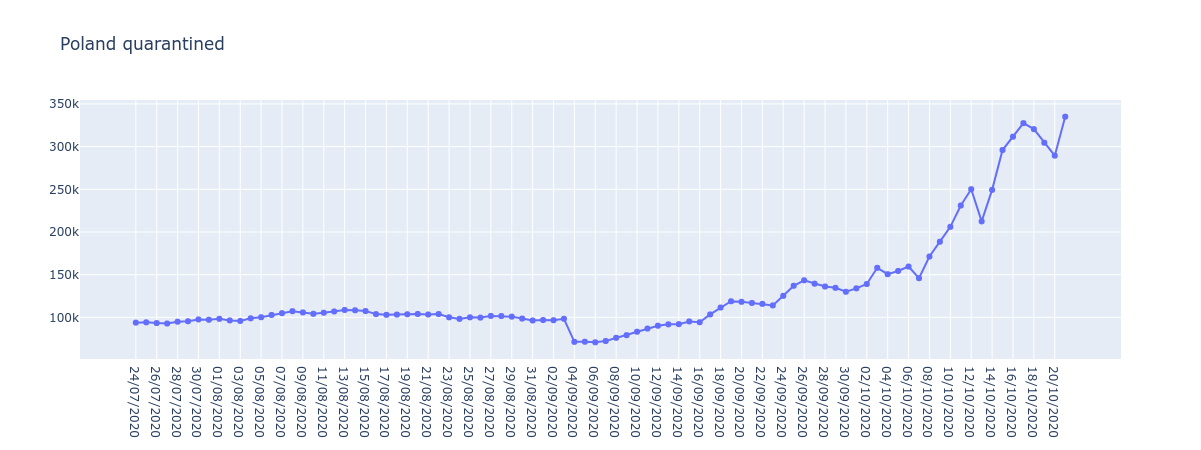

In [4]:
with tracer.start_as_current_span(f'Poland daily'):
    df = pl.covid_19_timeline()
    df["Quarantined percentage"] = df[pl.QUARANTINED].apply(lambda x: x*100/pl_population)
    df["Active percentage"] = df[pl.ACTIVE].apply(lambda x: x*100/pl_population)
    fig_pl.active_quarantined_percentage_chart(df, NO_OF_DAYS).show()
    fig_pl.cases_and_active(df, NO_OF_DAYS, 'Poland cases daily and active').show()
    fig_pl.deaths_and_recovered(df, NO_OF_DAYS, 'Poland deaths daily and recovered').show()
    fig_pl.quarantined(df, NO_OF_DAYS, 'Poland quarantined').show()

Poland (TODO: display map of voivodships)

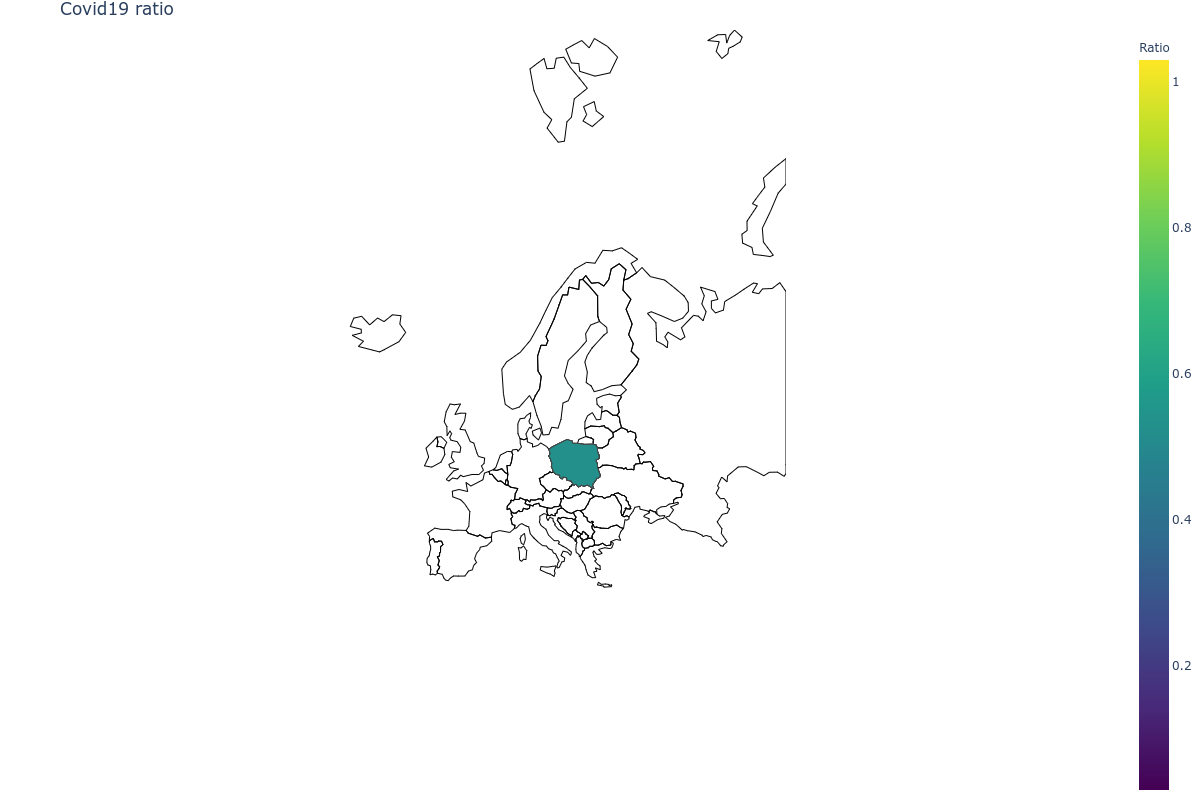

In [5]:
import plotly.graph_objects as go

summary = df.aggregate({pl.DEATHS_DAILY:['sum', 'max'], 
              pl.CONFIRMED_DAILY:['sum', 'max'],
              }) 

summary['confirmed ratio'] = summary[pl.CONFIRMED_DAILY]['sum']*100/population['Poland']
summary['country'] = 'Poland'
summary['active'] = df[pl.ACTIVE][-1]
summary['active ratio'] = summary.active*100/population['Poland']
layout = dict(title = 'Covid19 ratio',
              geo = dict(projection = {'type':'mercator'}),
              height=800,
              margin={"r":0,"t":30,"l":0,"b":0}
             )

data = dict(
        
        type = 'choropleth',
        colorscale = 'Viridis',
        locations = summary['country'],
        locationmode = "country names",
        z = summary['confirmed ratio'],
        text = summary['country'],
        colorbar = {'title' : 'Ratio'},
      )



choromap = go.Figure(data = [data],layout = layout)

choromap.update_geos(
    visible=False, scope="europe",
    showcountries=True, countrycolor="Black",
    showsubunits=True, subunitcolor="Blue"
)
choromap.show()

# Poland and few neighbors weekly

We may combine cases and deaths rates with testing against covid-19 and hospital admission rates if we aggregate data on a weekly basis

In [6]:
import World.figures as fig_w
import World.ecdc as ecdc

country_pop = {'Poland': population['Poland'],
               'Germany': population['Germany'],
               'Czechia': population['Czechia'],
               'Slovakia': population['Slovakia']}


with tracer.start_as_current_span(f'Countries weekly'):
    cases = ecdc.cases_by_country()
    testing = ecdc.testing_by_country_weekly()
    hospital_rates = ecdc.hospitel_admission_rates_weekly()

In [7]:
data = ecdc.weekly_all_countries(cases, testing, hospital_rates)

In [8]:
import pandas as pd
import World.ecdc as ecdc

df_countries = pd.DataFrame(data)  
countries_data = df_countries.loc[df_countries[ecdc.COUNTRY].isin(country_pop.keys())]
for country, population in country_pop.items():
    print(f'{country}: {round(population/1000000)}M')

Poland: 38M
Germany: 83M
Czechia: 11M
Slovakia: 5M


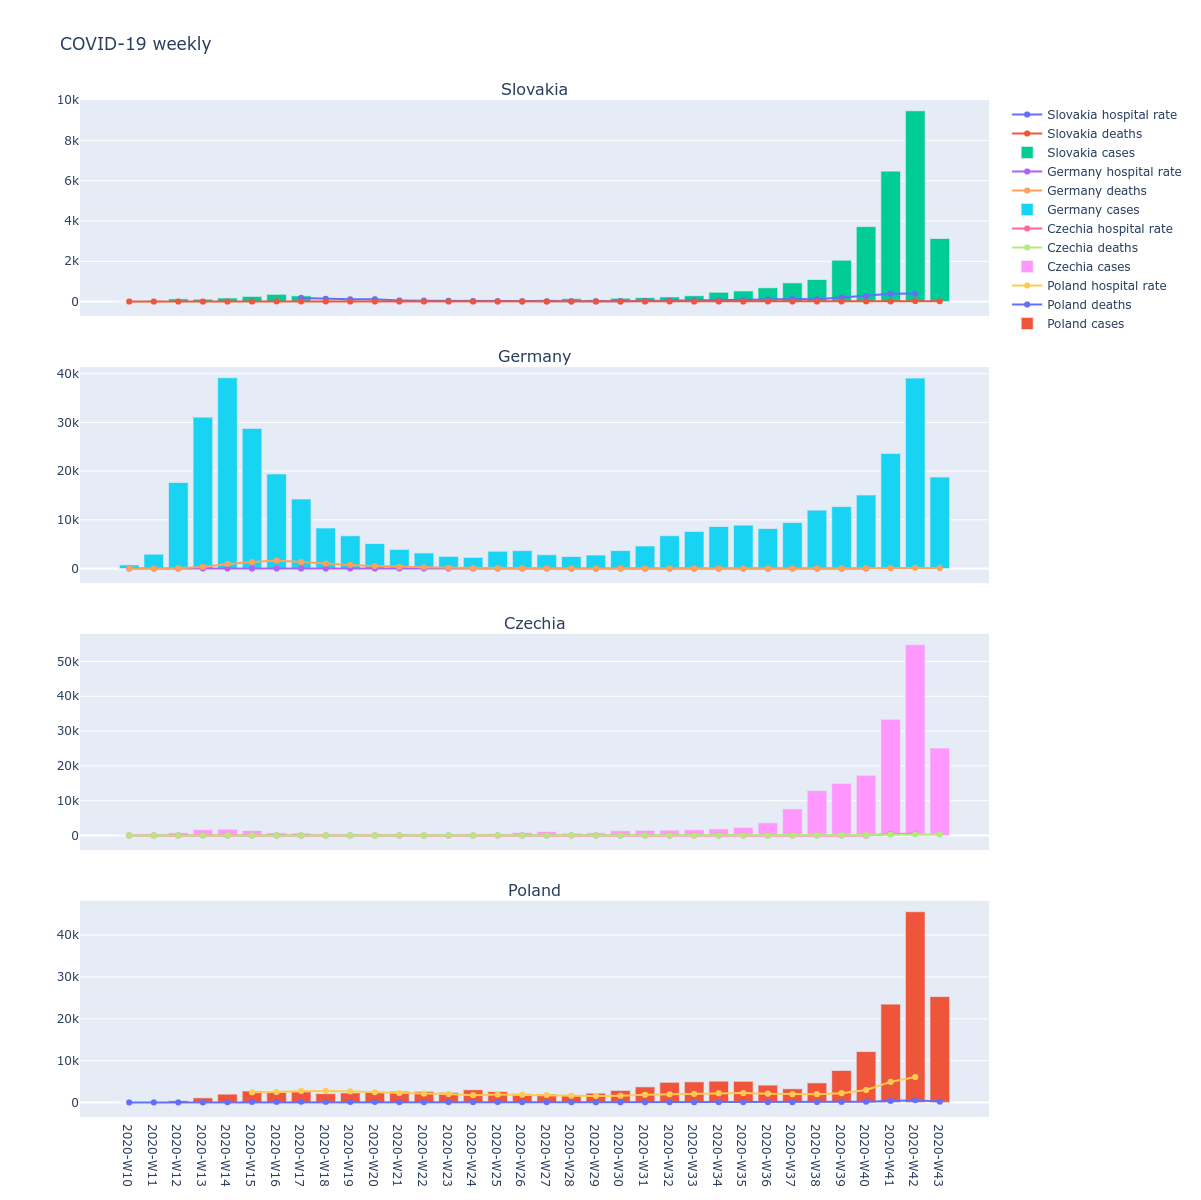

In [9]:
fig_w.case_distribution_subplots(countries_data, "COVID-19 weekly").show()